In [1]:
import pandas as pd
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

# gensim
import gensim
from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
import string


In [2]:
import re
from pymongo import MongoClient
client = MongoClient()
db = client.restaurant_gurugram
collection = db.noida_reviews

cursor = db.noida_reviews.find({}, {'_id':0,'id':0,'index':0})
df = pd.DataFrame(data=list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  5575 non-null   object
 1   info      5575 non-null   object
 2   loc       5575 non-null   object
 3   name      5575 non-null   object
 4   rating    5575 non-null   object
 5   summary   5575 non-null   object
 6   users     5575 non-null   object
dtypes: object(7)
memory usage: 305.0+ KB


In [3]:
df["name"] = df["name"].replace(r'([\d]+)\.','',regex=True)
df["sıralama"] = df["name"].str.extract('([\d]+)\. ', expand=False)
df = df.sort_values(by=["sıralama"])
df = df.drop(columns=["sıralama"]) # 24103
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5575 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  5575 non-null   object
 1   info      5575 non-null   object
 2   loc       5575 non-null   object
 3   name      5575 non-null   object
 4   rating    5575 non-null   object
 5   summary   5575 non-null   object
 6   users     5575 non-null   object
dtypes: object(7)
memory usage: 348.4+ KB


In [4]:
df = df.drop_duplicates(subset =["name","rating","comments"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  5572 non-null   object
 1   info      5572 non-null   object
 2   loc       5572 non-null   object
 3   name      5572 non-null   object
 4   rating    5572 non-null   object
 5   summary   5572 non-null   object
 6   users     5572 non-null   object
dtypes: object(7)
memory usage: 348.2+ KB


In [5]:
df = df.reset_index()

val = df["loc"].to_list()

new =[]

for v in val:
    if(len(v)==2 or len(v)==1):
        new.append(str(v[0]))
    else:
        new.append(str(v))
df["loc"] = new

df.rating = df.rating.astype("int")

df["info"] = df["info"].fillna("")

In [6]:
df["info"] = df["info"].apply(lambda x: " ".join(x))

df = df.drop(columns=["index"])

df.rating = df.rating.apply(lambda x: int(x)/10)

df["street"] = df["loc"].apply(lambda x : x.split(",")[0])
df["postCode"] = df["loc"].apply(lambda x :x.split(",")[-1])

df = df.drop(columns=["loc"])
name_list = list(df.name.unique())

df1 = df[df["name"].isin(name_list)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


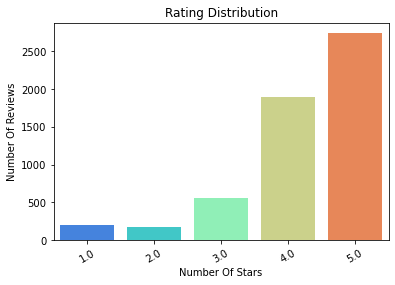

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(df1.rating.value_counts().sort_values(ascending=True).index,
                 y=df1.rating.value_counts().sort_values(ascending=True),palette="rainbow")
plt.title("Rating Distribution")
plt.xlabel("Number Of Stars")
plt.ylabel("Number Of Reviews")
plt.xticks(rotation=30)
plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [8]:
df1 = df1[df1.rating!=3]

import numpy as np
df1['sentiment'] = np.where(df1['rating'] >= 4, 'positive', 'negative')

df1.sentiment.value_counts(normalize=True)

2021-10-21 19:53:05,616 : INFO : NumExpr defaulting to 8 threads.


positive    0.92515
negative    0.07485
Name: sentiment, dtype: float64

In [9]:
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
s_words= list(stopwords.words('english'))
stop_words = list(STOPWORDS)+ ["what", "us", "this","well","there","much","us","and","you're","in","where","when","just","how","is","ha","re","are"
                              "hi","aren't", 'couldn','could','couldnt',"couldn't",'did','had','have','must','does','should','was',"it's"
                               "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'let', 'll',"may",'were','is','has','must',
                               'mustn', 'rt', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','realli','now','got','man','people','a',
                               'becaus','caus',"one","im","guy","someone","two","nearby","i","he's","she's","we","it","they","wouldn’t","i've",
                               'aren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'sdidn', 've',"will","restaurant"]


def remove_stopwords(txt):
    
    sentence = []
    s = ""
    for word in txt.split():    
        if(word not in stop_words):      
            sentence.append(word)
            s = ' '.join(sentence)
    return s

df1.comments = df1.comments.map(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dunga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
nltk.download("wordnet")
def lem_words(text):
    
    return " ".join([lemm.lemmatize(word) for word in text.split()])
    


df1.comments = df1.comments.apply(lambda metin: lem_words(metin))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dunga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
df1.summary = df1.summary.fillna("")

In [12]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


df1.summary = df1.summary.map(alphanumeric).map(punc_lower)
df1.comments = df1.comments.map(alphanumeric).map(punc_lower)

In [13]:
def remove_url(txt):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',txt)

def remove_html(txt):
    html=re.compile(r'<.*?>')
    return html.sub(r'',txt)

# U+1F970
def remove_emoji(txt):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)
def remove(emoji):
    em = re.compile(r"🥰")
    return em.sub(r"",emoji)
def remove_blank_space(text):
    return re.sub("\s\s+" , " ", text)
def remove_blank2(text):
    text = text.strip()
    return text
def remove_all(ReviewText):
    ReviewText = ReviewText.replace("(<br/>)", "")
    ReviewText = ReviewText.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.replace('(&amp)', '')
    ReviewText = ReviewText.replace('(&gt)', '')
    ReviewText = ReviewText.replace('(&lt)', '')
    ReviewText = ReviewText.replace('(\xa0)', ' ') 
    ReviewText = ReviewText.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText

    
df1.comments = df1.comments.apply(remove_url)
df1.comments = df1.comments.apply(remove_html)
df1.comments = df1.comments.apply(remove_emoji)
df1.comments = df1.comments.apply(remove)
df1.comments = df1.comments.apply(remove_blank_space)
df1.comments = df1.comments.apply(remove_blank2)
df1.comments = df1.comments.apply(remove_all)
df1.comments = df1.comments.map(remove_stopwords)


--------Top 300 R - All Reviews-------------


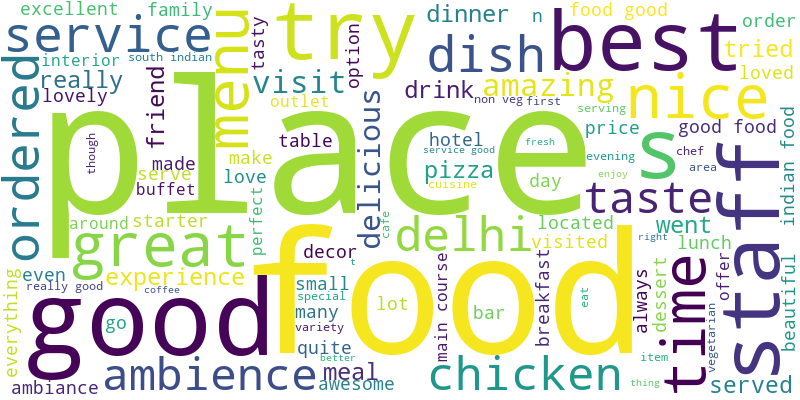

In [14]:
from wordcloud import WordCloud

txt = ','.join(list(df1.comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Top 300 R - All Reviews-------------")
wordcloud.to_image()

In [15]:
# wordcloud.to_file("a_reviews.png")

--------Negative Reviews-------------


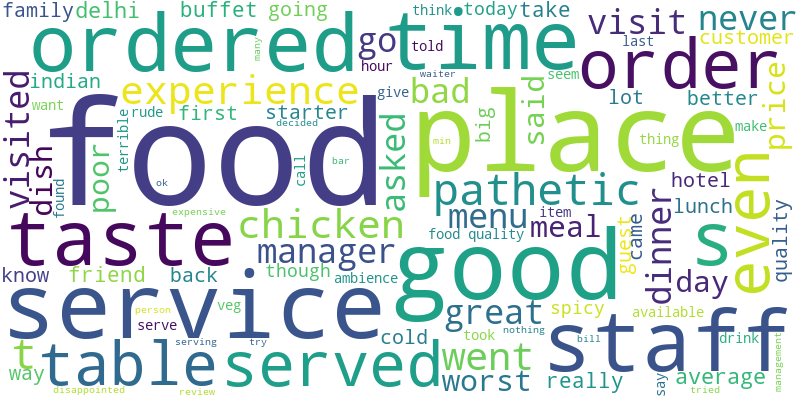

In [16]:
txt = ','.join(list(df1[df1.sentiment=="negative"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
wordcloud.to_file("n_reviews.png")
# Visualize the word cloud
print("--------Negative Reviews-------------")
wordcloud.to_image()

--------Positive Reviews-------------


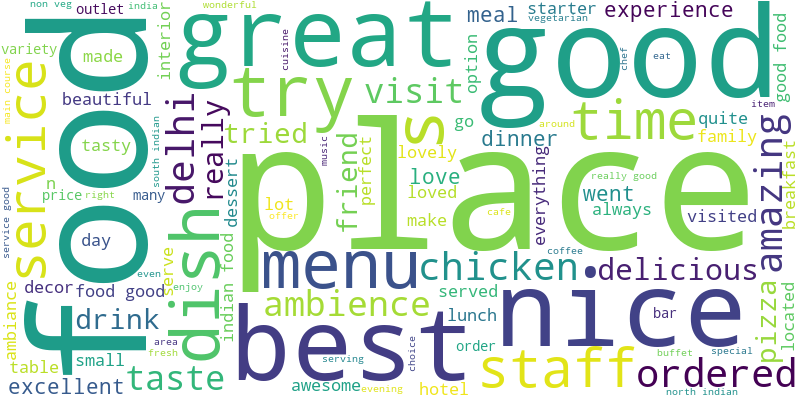

In [17]:

txt = ','.join(list(df1[df1.sentiment=="positive"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Positive Reviews-------------")
wordcloud.to_image()

In [18]:
# wordcloud.to_file("positive_reviews.png")

In [19]:
stopw = stop_words + ["food","dinner","menu","service","staff","starter","place","meal","lunch","drink","restaurant","burger","pub",
              "waiter","family","wine","main","bar","eat","area","evening","pizza","came","went","made","dessert","breakfast",
              "cocktail","table","booked","london","way","many","think","another","took","pasta","fish","dish","pay","going",
              "dessert","wife","came","go","say"]

In [20]:
from collections import Counter
c = Counter()
for txt in df1.comments.values:
    for word in txt.split():
        c[word] += 1
set([w for (w, wc) in c.most_common()[:-29:-1]])        

{'abbreviated',
 'accomodate',
 'aeound',
 'aunty',
 'bolywood',
 'booth',
 'clubbing',
 'drinks”',
 'gunda',
 'hearts',
 'iron',
 'ishaan',
 'junction',
 'kust',
 'latter',
 'magenta',
 'potstickers',
 'raging',
 'realistically',
 'saucer',
 'sliver',
 'sukhuja',
 'teaspoon',
 'throne',
 'trilogy',
 'vacant',
 'violet',
 '“lord'}

--------Restaurant Information-------------


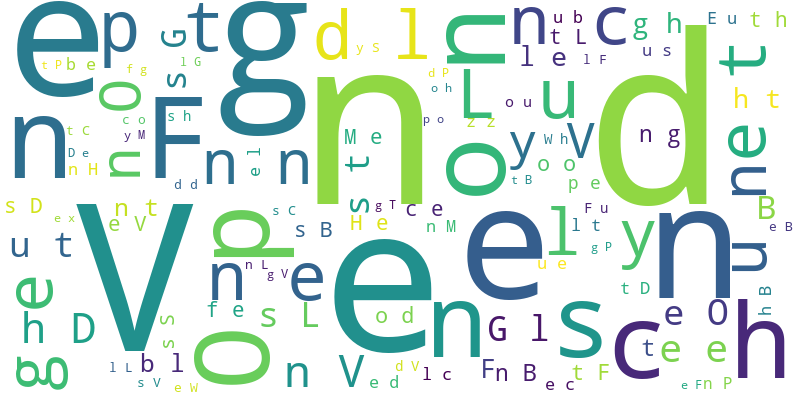

In [21]:
#stopwords2= stopwords+["TRY\\xa0"]

txt = ','.join(list(df1["info"].fillna(" ").values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
#wordcloud.to_file("restaurant_info.png")
# Visualize the word cloud
print("--------Restaurant Information-------------")
wordcloud.to_image()

In [22]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stem_words(text):

    return " ".join([stemmer.stem(word) for word in text.split()])
df1.comments = df1.comments.apply(lambda txt: stem_words(txt))

from textblob import TextBlob
df1['polarity'] = df1['comments'].map(lambda text: TextBlob(text).sentiment.polarity)

mc = c.most_common(20)

df2 = pd.DataFrame(mc,columns=["word","freq"])

In [23]:
import plotly.express as px

fig = px.bar(df2, x='word', y='freq',
             hover_data=['word', 'freq'], color='freq',
             title='Most Common 20 Words',
             height=400)
fig.show()

In [24]:
df1["word count"] = df1.comments.str.len()

fig = px.histogram(df1, x="word count", nbins=200, title='Word Count')
fig.show()

In [25]:
fig = px.histogram(df1, x="polarity", nbins=20, title='Text Polarity')
fig.show()

In [26]:
df1.sentiment = df1.sentiment.map({"negative":0,"positive":1})
name_list = list(df1.groupby("name")["sentiment"].mean().sort_values(ascending=False).head(10).index)

df1.groupby("name")["polarity"].mean().sort_values(ascending=True).head(10)

name
 Kapoors Balle Balle              0.042338
 Asian Fun                        0.062657
 Zooby's Kitchen                  0.107422
 Nando's Epicuria                 0.108211
 Moti Mahal Deluxe 2              0.130383
 Nooshe Joon                      0.138925
 The Flying Dutchman              0.144738
 The American Connection Diner    0.157377
 Not Just Paranthas               0.172347
 A Grill Company                  0.195117
Name: polarity, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' Mitra Di Chaap'),
  Text(1, 0, ' The Flying Dutchman'),
  Text(2, 0, ' Jungle Jumbooree'),
  Text(3, 0, ' Lord of the Drinks - Forum'),
  Text(4, 0, ' Suruchi')])

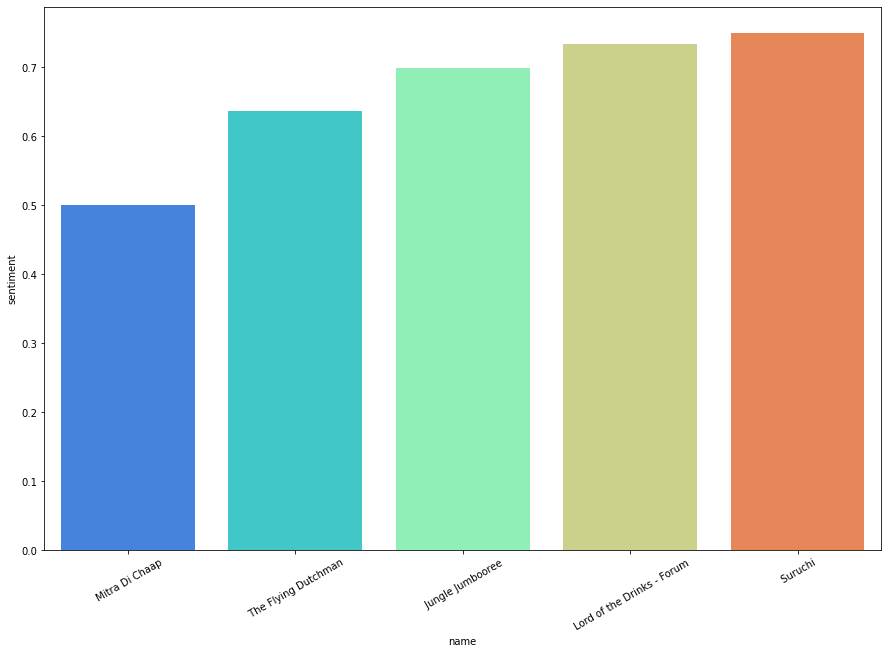

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.barplot(df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5).index,
                 y=df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5),palette="rainbow")
plt.xticks(rotation=30)
#plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [28]:
import plotly.express as px
fig = px.box(df1[df1.name.isin(name_list)], x="name",y='polarity', color="name",
             title="Polarity based On Restaurant Name",
             hover_data=["polarity"])
fig.show()

In [29]:

df1 = df1.drop(columns=["users"])
df1 = df1.drop_duplicates()

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

def model_produce(X,y,model,min_df,ngram_range):
    m = model(stop_words=stopw, min_df=min_df,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b",ngram_range=ngram_range)
    m2 = m.fit_transform(X)
    # modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
   # m3  = pd.concat([df1["polarity"],modeldf],axis=1)
    X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
    X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)
  
    return X_train, X_test, y_train, y_test

In [31]:
from collections import Counter

X = df1.comments
y = df1.sentiment

model = TfidfVectorizer
ngram_range =(1,2)
X_train, X_test, y_train, y_test = model_produce(X,y,model,1,ngram_range)


Counter(y_train)

Counter({1: 263, 0: 262})

In [32]:
import eli5
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predict Negative', 'predict Positive'], 
                yticklabels=['actual Negative', 'actual Positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    print(cm_results)
    return cm_results

In [33]:
perform_list = []
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import time
kf = StratifiedKFold(n_splits=10, random_state=42,shuffle=True)
def calculate_metrics(model, X_train, X_test, y_train, y_test):
    begin = time.time()
    model.fit(X_train, y_train)
    now =time.time()
    y_pred = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(model)
    print('CV accuracy:', test_accuracy)
    print('Precision:{:6.4f},   Recall:{:6.4f}, F1:{:6.4f}'.format(precision, 
                                                                   recall, f1))
    cv_acc = cross_val_score(model, X_train, y_train, cv=kf,scoring="accuracy").mean()
    cv_f1 = cross_val_score(model, X_train, y_train, cv=kf,scoring="f1").mean()
    perform_list.append(dict([
            ("Model" , model.__class__.__name__),
            ("Time x 1000",(now-begin)*1000),
            ("Train Accuracy", model.score(X_train,y_train)),
            ("Test Accuracy", test_accuracy),
            ("Precision" , precision ),
            ("recall",recall),
            ("f1",f1),
            ("CV Accuracy",cv_acc),
            ("CV f1",cv_f1)]))

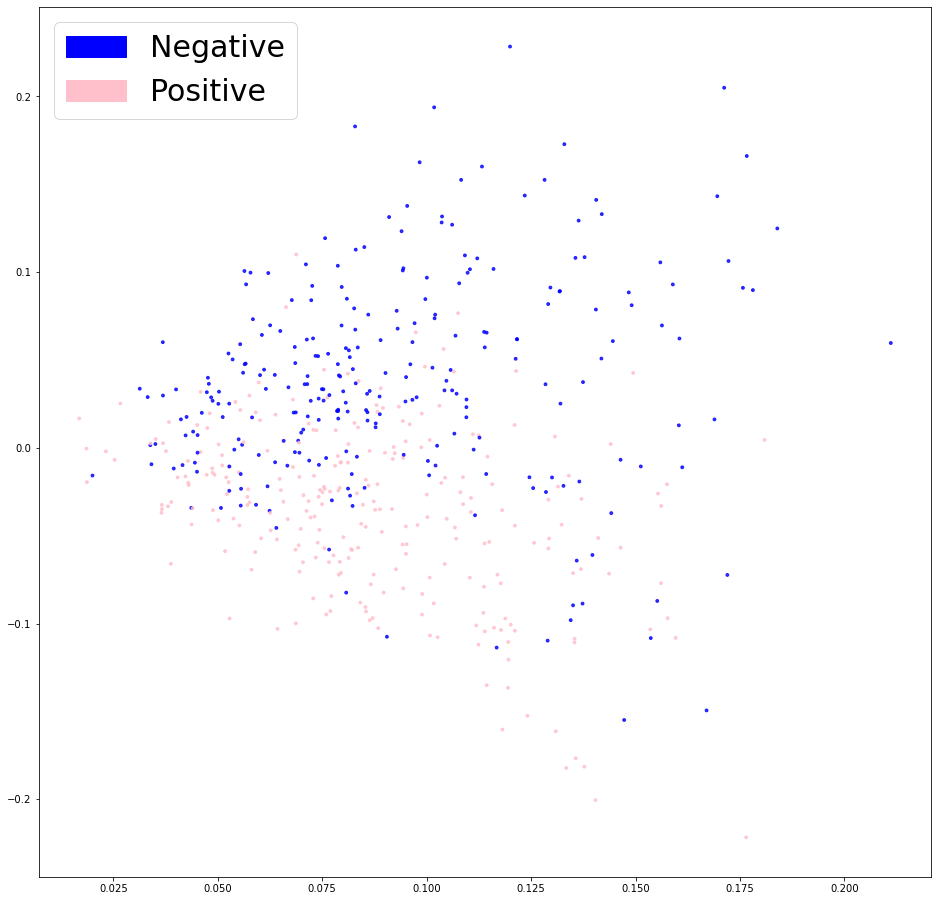

In [34]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','pink','pink']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Negative')
            green_patch = mpatches.Patch(color='pink', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
# plt.show()

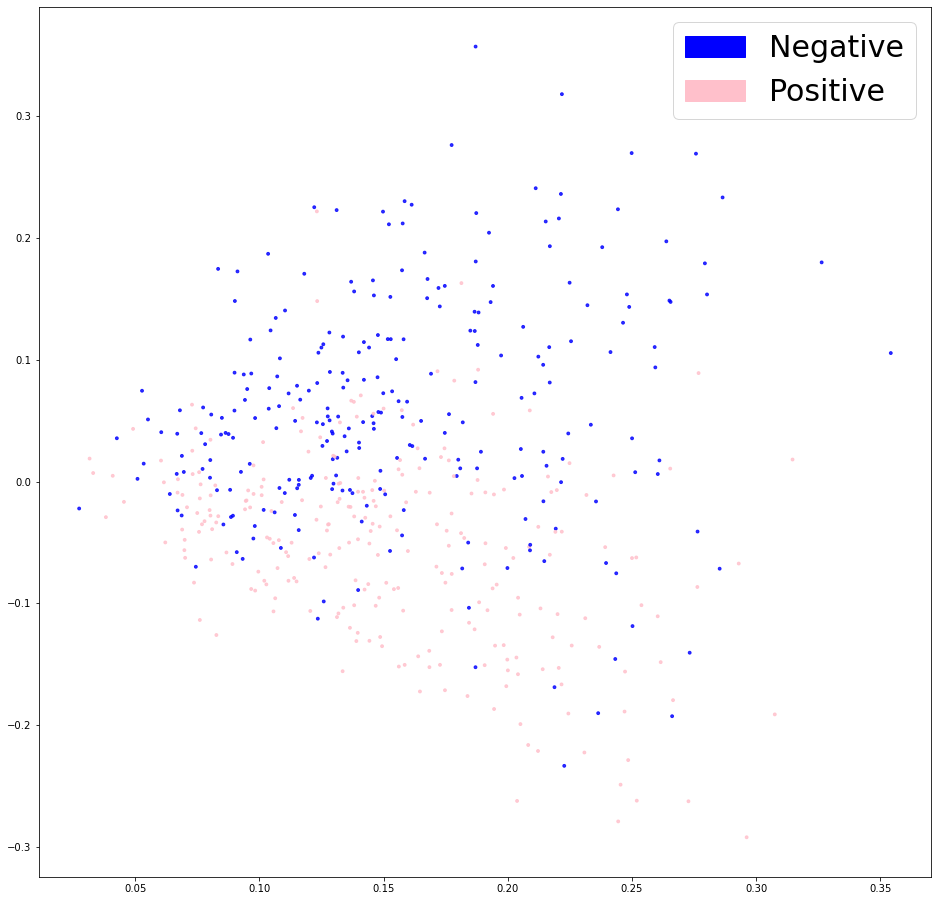

In [35]:
model = TfidfVectorizer
ngram_range = (1,1)

X_train2, X_test2, y_train2, y_test2  = model_produce(X,y,model,4,ngram_range)

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train2, y_train2)
# plt.show()

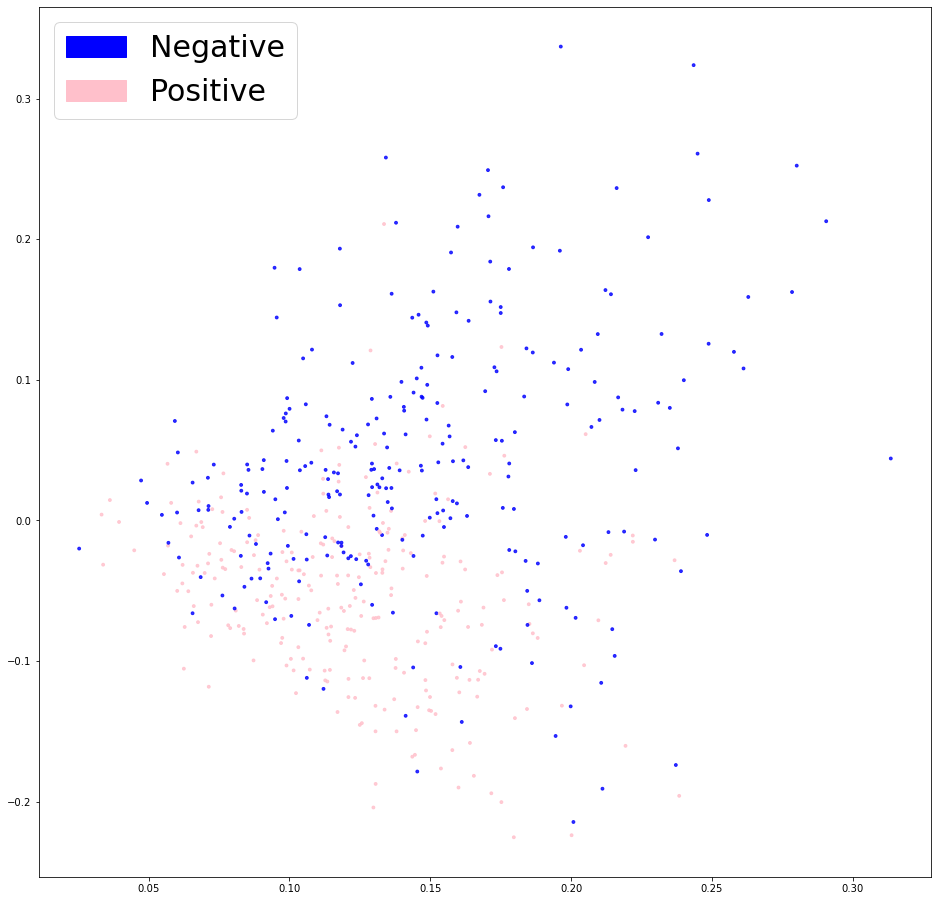

In [36]:
model = TfidfVectorizer
ngram_range =(1,2)


X_train3, X_test3, y_train3, y_test3  = model_produce(X,y,model,4,ngram_range)


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train3, y_train3)
# plt.show() 

In [37]:
from sklearn.metrics import  precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
perform_list = []
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


for model in models:
    calculate_metrics(model,X_train2, X_test2, y_train2, y_test2)
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8755555555555555
Precision:0.8559,   Recall:0.9018, F1:0.8783
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.8222222222222222
Precision:0.8273,   Recall:0.8125, F1:0.8198
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.8888888888888888
Precision:0.8783,   Recall:0.9018, F1:0.8899
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8933333333333333
Precision:0.8667,   Recall:0.9286, F1:0.8966
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.84
Precision:0.8455,   Recall:0.8304, F1:0.8378
------------------Model Result :---------------------
[19:54:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'loglos

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CV accuracy: 0.8044444444444444
Precision:0.7982,   Recall:0.8125, F1:0.8053
[19:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------Model Result :---------------------
LinearSVC()
CV accuracy: 0.8533333333333334
Precision:0.8319,   Recall:0.8839, F1:0.8571
------------------Model Result :---------------------


In [38]:
per = pd.DataFrame(perform_list)
per = per[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
# per

[0.871, 0.849, 0.902, 0.875]


[0.871, 0.849, 0.902, 0.875]

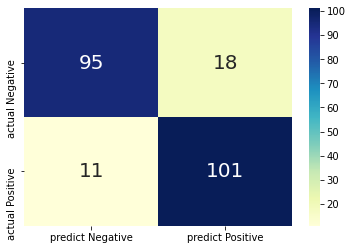

In [39]:

mb2 = LogisticRegression() # LogReg, Multi, Bernoulli
mb2.fit(X_train2, y_train2)

y_pred1 = mb2.predict(X_test2)

conf_matrix(y_test2,y_pred1)

[0.889, 0.878, 0.902, 0.89]


[0.889, 0.878, 0.902, 0.89]

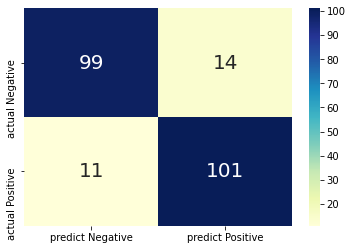

In [40]:
mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [41]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, random_state=42,shuffle=True)

import numpy as np

mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 1.2857142857142858}

[0.889, 0.878, 0.902, 0.89]


[0.889, 0.878, 0.902, 0.89]

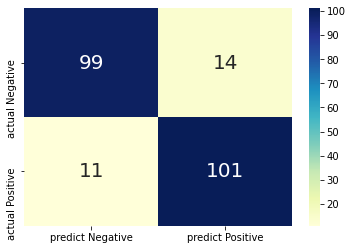

In [42]:
mnb = MultinomialNB(alpha = 2.2040816326530615)
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [43]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

lr = LogisticRegression()

clf2 = GridSearchCV(lr, grid, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan 0.5990566         nan 0.76748911        nan 0.81694485
        nan 0.82071843        nan 0.80152395        nan 0.78820755
        nan 0.78055152]



{'C': 1.0, 'penalty': 'l2'}

[0.862, 0.829, 0.911, 0.868]


[0.862, 0.829, 0.911, 0.868]

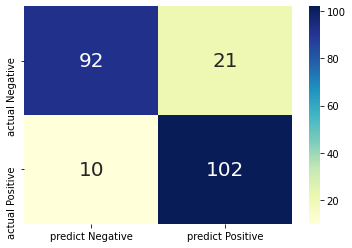

In [44]:
lr = LogisticRegression(C = 0.1, penalty = 'l2')
lr.fit(X_train2, y_train2)

y_pred1 = lr.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [45]:

m = TfidfVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
m3  = pd.concat([df1["polarity"],modeldf],axis=1)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)

eli5.show_weights(lr, vec=m)

In [46]:
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


m = CountVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)




for model in models:
    calculate_metrics(model,X_trainc, X_testc, y_trainc, y_testc )
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8488888888888889
Precision:0.8421,   Recall:0.8571, F1:0.8496
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.8711111111111111
Precision:0.8547,   Recall:0.8929, F1:0.8734
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.8888888888888888
Precision:0.8655,   Recall:0.9196, F1:0.8918
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8933333333333333
Precision:0.8667,   Recall:0.9286, F1:0.8966
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.8711111111111111
Precision:0.8609,   Recall:0.8839, F1:0.8722
------------------Model Result :---------------------
[19:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CV accuracy: 0.8577777777777778
Precision:0.8448,   Recall:0.8750, F1:0.8596


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[19:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------Model Result :---------------------
LinearSVC()
CV accuracy: 0.8
Precision:0.7863,   Recall:0.8214, F1:0.8035
------------------Model Result :---------------------


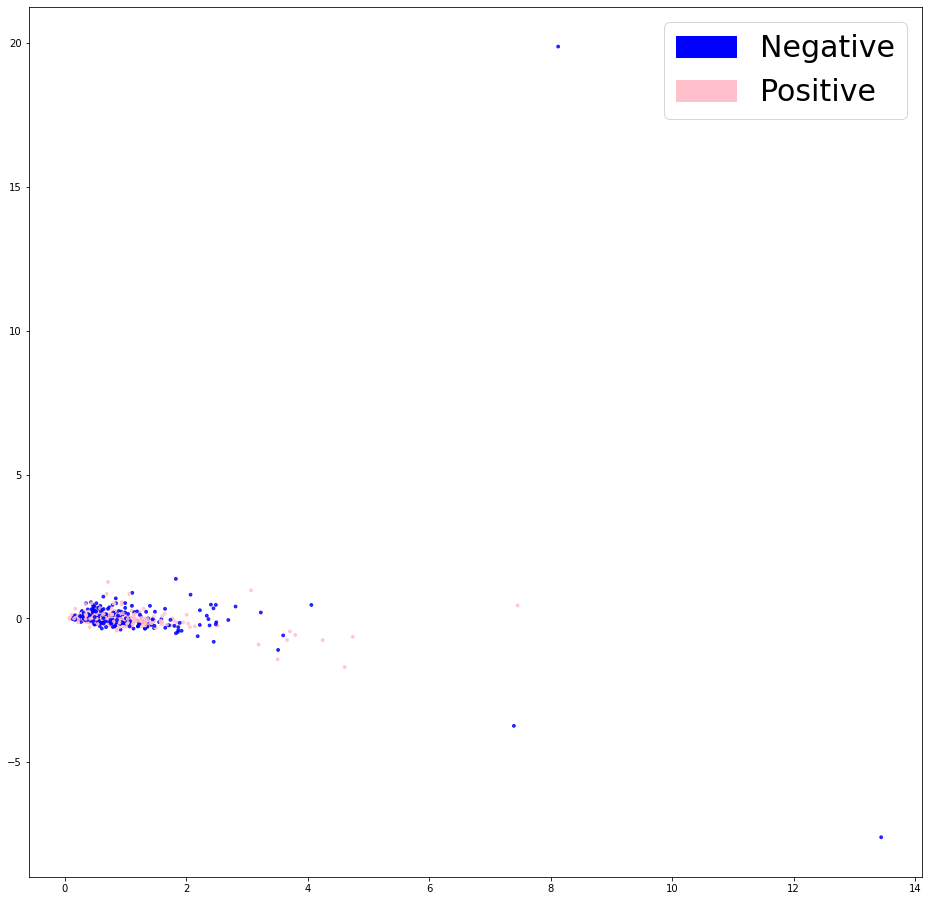

In [47]:

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_trainc, y_trainc)
# plt.show()

In [48]:
per2 = pd.DataFrame(perform_list)
per2 = per2[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
# per2

[0.889, 0.866, 0.92, 0.892]


[0.889, 0.866, 0.92, 0.892]

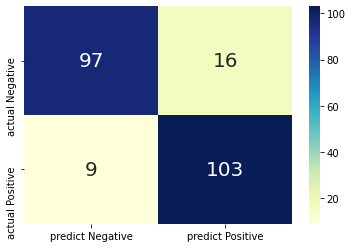

In [49]:

mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [50]:
mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0.0001,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 1.2858}

[0.889, 0.866, 0.92, 0.892]


[0.889, 0.866, 0.92, 0.892]

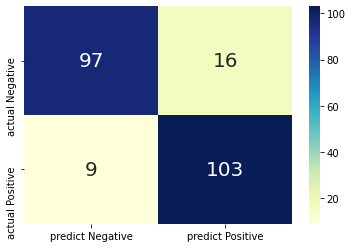

In [51]:
mnb = MultinomialNB(alpha = 2.204157142857143)
mnb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [52]:
parameters = [{'alpha':np.linspace(0.1,1,10)}]


clf = GridSearchCV(BernoulliNB(), parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)
clf.fit(X_trainc, y_trainc) # running the grid search
clf.best_params_

{'alpha': 0.8}

[0.871, 0.843, 0.911, 0.876]


[0.871, 0.843, 0.911, 0.876]

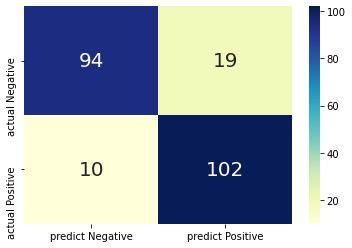

In [53]:
bnb = BernoulliNB(alpha = 0.30000000000000004)
bnb.fit(X_trainc, y_trainc)

y_pred1 = bnb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [54]:
mb = MultinomialNB().fit(X_train2, y_train2)


y_pred1 = mb.predict(X_test2)

lr_proba = lr.predict_proba(X_test2)
nb_proba = mb.predict_proba(X_test2)
nb_proba2 = mnb.predict_proba(X_testc)
#l_propba = LSVC.predict_proba(X_test2)

def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2    
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test2, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test2, lr_proba[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR-TFIDF, auc=%.3f' % auc_lr)
         
    
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba[:,1], pos_label=1)
    auc_nbc = roc_auc_score(y_test2, nb_proba[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='Naive Bayes-TFIDF, auc=%.3f' % auc_nbc)

    # Naive Bayes 2
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba2[:,1], pos_label=1)
    auc_nb = roc_auc_score(y_testc, nb_proba2[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Naive Bayes-CF, auc=%.3f' % auc_nbc)

    
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig("roc.jpeg",dpi=300,bbox_inches="tight")
# plot_roc_curves()

In [55]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

df.summary = df.summary.fillna("")

# df.info()

In [56]:
rec = pd.DataFrame(df[["info","summary"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rec["name"] = df["name"]

rec = rec.drop_duplicates()
# rec.info()

In [57]:
all_comments = df.groupby("name",as_index=False).agg({"comments" : lambda x: " ".join(x)})
all_comments = all_comments.drop_duplicates()
# all_comments.info()

In [58]:
rec = pd.merge(rec, all_comments, how='inner')
rec.full = rec.full.fillna("")
# rec.info()

In [59]:
rec = rec.drop_duplicates()
# rec.info()

In [60]:
rc = pd.DataFrame(rec[["comments","full"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rc["name"] =rec["name"]

rc = rc.drop_duplicates()
# rc.info()

In [61]:

rc = rc.drop_duplicates(subset=["name"])
rc["name"] =rec["name"]

# rc.full.nunique()

In [62]:
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=1,max_df=.85,ngram_range=(1, 3), token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rc.full)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

import pickle
with open('cosine_sim_noida.pickle', 'wb') as handle:
    pickle.dump(cosine_sim, handle)

In [63]:
indices = pd.Series(rc.name)
indices

0                                  I Sacked Newton
1       Edesia, Crowne Plaza Today New Delhi Okhla
2                                The Golden Dragon
3                                    Afghan Darbar
4                                Atul Chaat Corner
                          ...                     
141                                       The Qube
142                            Moti Mahal Deluxe 2
143                                  Shree Rathnam
144                                          Baris
145                     Lord of the Drinks - Forum
Name: name, Length: 140, dtype: object

In [64]:

indices.to_csv("indices_noida.csv")

In [65]:
import pandas as pd
indices = pd.read_csv("indices_noida.csv")

indices = indices["name"]
# indices

In [66]:
# rc = rc.reset_index()

def get_recommendation(title, cosine_sim ,top_n):
    
    '''
    I choose the restaurant which is not null restaurant information
    '''    
    recommended_restaurant = []    
    # restaurant match indices
    idx = indices[indices == title].index[0]
    # similarity scores
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    # top n
    top_n_indexes = list(score_series.iloc[1:top_n+1].index)
    for i in top_n_indexes:
        recommended_restaurant.append(list(indices)[i])
        
    return recommended_restaurant

In [69]:
get_recommendation(" Om Sweets & Snacks", cosine_sim ,5)

[' Anupama Sweets & Restaurant',
 " Haldiram's",
 ' Tama Brewery & World Kitchen',
 ' Saravana Bhavan',
 ' Naivedyam']

In [70]:

# Just Reviews

rec = df.groupby("name",as_index=False).agg({"comments": lambda x: " ".join(x)})

rec.comments = rec.comments.map(remove_stopwords) 
rec.comments = rec.comments.apply(remove_blank_space)
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.map(alphanumeric).map(punc_lower)

In [71]:
rec = rec.reset_index()

tfidf_vec = TfidfVectorizer(stop_words="english",min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rec.comments)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

In [72]:
indices = pd.Series(rec.name)

# get_recommendation(" Pan Asian", cosine_sim ,5)